# Imports

In [1]:
from seaexplorertools import process_adcp
import xarray as xr
import numpy as np
import pandas as pd

# 1 Calculate shear

This process is shown in much more detail in notebook **01_calculate_velocity_shear**

In [2]:
adcp_path = 'ADCP_refactoring_test_files/sea045_M44.ad2cp.00000*.nc'
glider_pqt_path = 'ADCP_refactoring_test_files/Skag_test.pqt'

options = {
    'debug_plots' : False,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard, in future we should extend blanking distance
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    }


In [3]:
ADCP, data, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)
data = data[data.profile_number < 199]
ADCP = ADCP.where(ADCP.time < data.time.values[-1]).dropna(dim="time", how="all")
ADCP = process_adcp.remapADCPdepth(ADCP, options)
ADCP = process_adcp.correct_heading(ADCP, data, options)
ADCP = process_adcp.soundspeed_correction(ADCP)
ADCP = process_adcp.remove_outliers(ADCP, options)
ADCP = process_adcp.correct_shear(ADCP, options)
ADCP = process_adcp.correct_backscatter(ADCP, data, options)
ADCP = process_adcp.regridADCPdata(ADCP, options)
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)

Loaded ADCP_refactoring_test_files/Skag_test.pqt
2023-07-24 11:48:58 : Finished loading ADCP data
2023-07-24 11:48:59 : Added glider variables
2023-07-24 11:48:59 : top mounted: True
2023-07-24 11:48:59 : Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)
        <total-intensity units="nT">51043</total-intensity>

Target = 510.43
Optimization terminated successfully.
         Current function value: 1.707746
         Iterations: 1392
         Function evaluations: 1935
[[ 0.8218908  -0.00215635 -0.0088071 ]
 [-0.00226646  0.86730429 -0.02489248]
 [-0.02411338  0.00473393  0.85283387]]
[ 0.07404023 -0.05074324  0.03226842]
2023-07-24 11:49:11 : Corrected heading and accounted for declination
2023-07-24 11:49:11 : Corrected beam 1 velocity for sound speed.
2023-07-24 11:49:11 : Corrected beam 2 velocity for sound speed.
2023-07-24 11:49:11 : Corrected beam 3 velocity for sound speed.
2023-07-24 11:49:11 : Corrected beam 4 velocit

# 2 Integrate shear

After calculating velocity shear, there are several options for integrating and referencing this shear to obtain velocity profiles. This notebook demonstrates some of these options

# 2.1 Add extra variables for integrating shear

To calculate dive average current we require more variables, including estimates of the glider's movement through the water.

In [4]:
extra_data = pd.read_parquet(glider_pqt_path)
extra_data.index = extra_data.Timestamp
data["speed_vert"] = extra_data["speed_vert"]
data["speed_horz"] = extra_data["speed_horz"]
data["DeadReckoning"] = extra_data["DeadReckoning"]
data["NAV_RESOURCE"] = extra_data["NAV_RESOURCE"]
data["diveNum"] = extra_data["diveNum"]
options["debug_plots"] = True

## 2.2. Calculate dive-averaged current

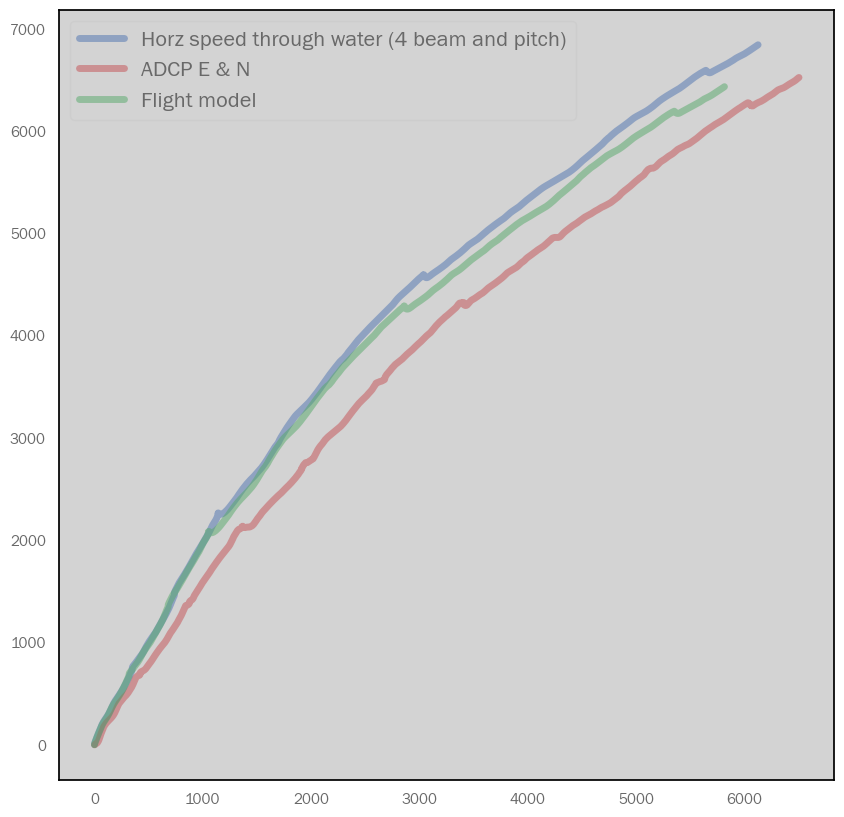

In [5]:
process_adcp.plot_subsurface_movement(ADCP, data)

No final GPS for dive 97.0


<Figure size 1500x700 with 0 Axes>

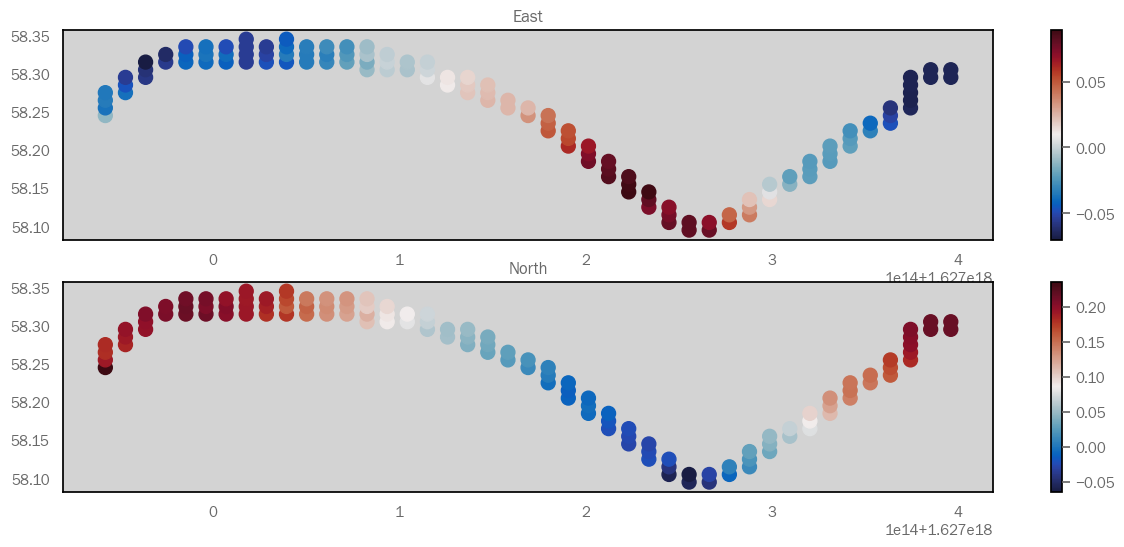

In [6]:
data = process_adcp.get_DAC(ADCP, data, options)

## 2.3. Get surface drift

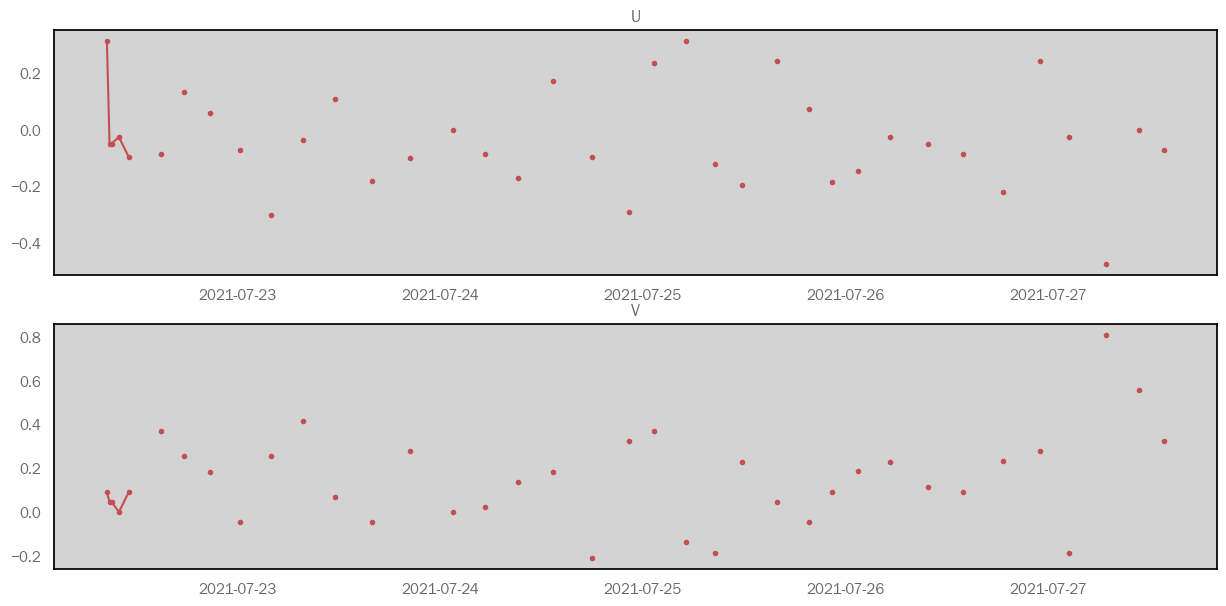

In [7]:
dE,dN,dT = process_adcp.getSurfaceDrift(data, options)

## 2.4. Get bottom track data 
Bottom track data only calculated if the ADCP is bottom mounted

In [8]:
ADCP = process_adcp.bottom_track(ADCP, adcp_path, options)

2023-07-24 11:49:23 : ERROR: ADCP is top mounted. Not processing bottom track data


## 2.5. Reference ADCP data

Here we reference data to dive average current (DAC).

/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1717: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis, yaxis, V, cmap=cmo.balance, shading='auto')
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1717: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis, yaxis, V, cmap=cmo.balance, shading='auto')


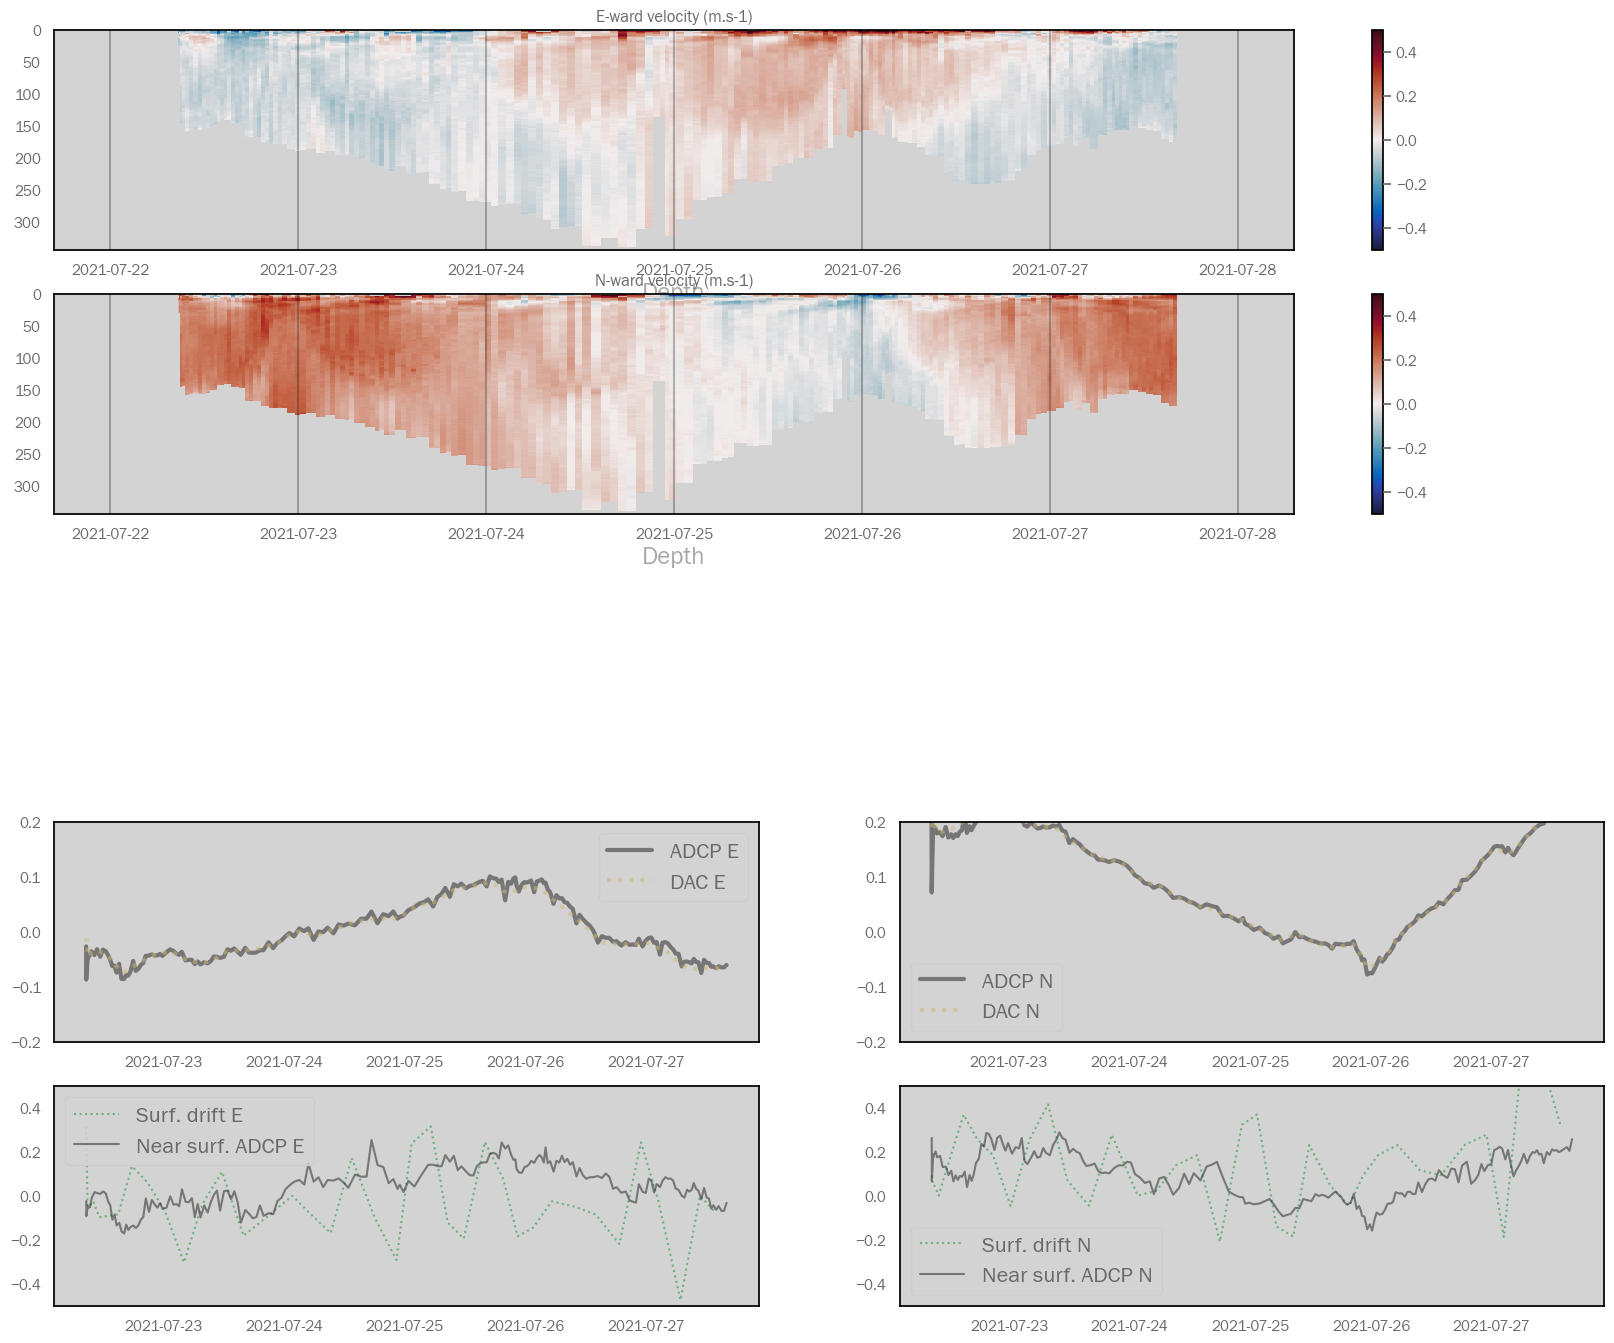

In [9]:
out = process_adcp.reference_shear(ADCP, data, dE,dN,dT, xaxis, yaxis, taxis, options)

# VI. Grid and plot data

In [10]:
out = process_adcp.grid_data(ADCP, data, out, xaxis, yaxis)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 26.18it/s]


/home/callum/anaconda3/envs/new/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges


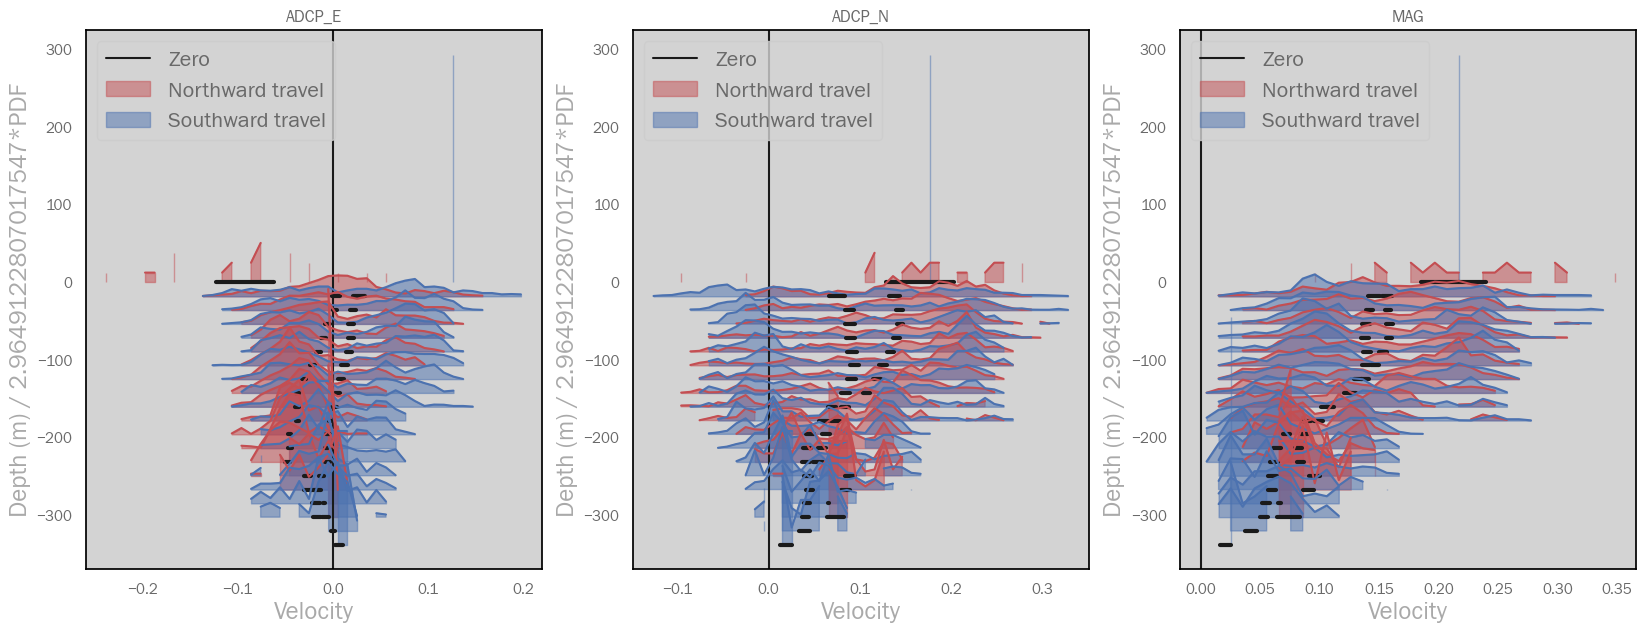

In [11]:
process_adcp.verify_depth_bias(out, yaxis)

 27%|███████████                              | 27/100 [00:00<00:00, 310.57it/s]


Optimization terminated successfully.
         Current function value: 165543.981953
         Iterations: 27
         Function evaluations: 54
(array([0.00090637]), 165543.98195338188, 27, 54, 0)


/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1993: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis, yaxis, out['ADCP_E'], cmap=cmo.balance, shading='auto')
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:2004: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis, yaxis, out['ADCP_E'], cmap=cmo.balance, shading='auto')


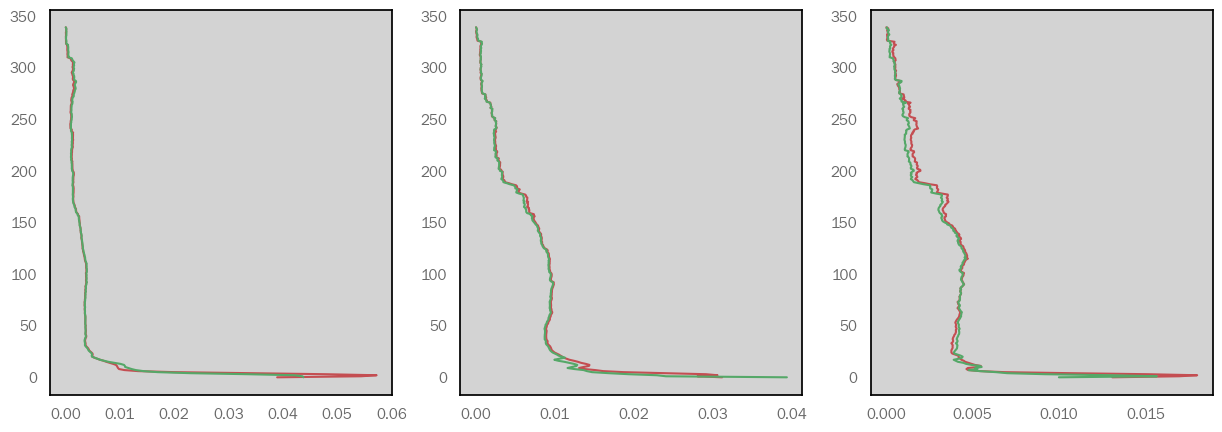

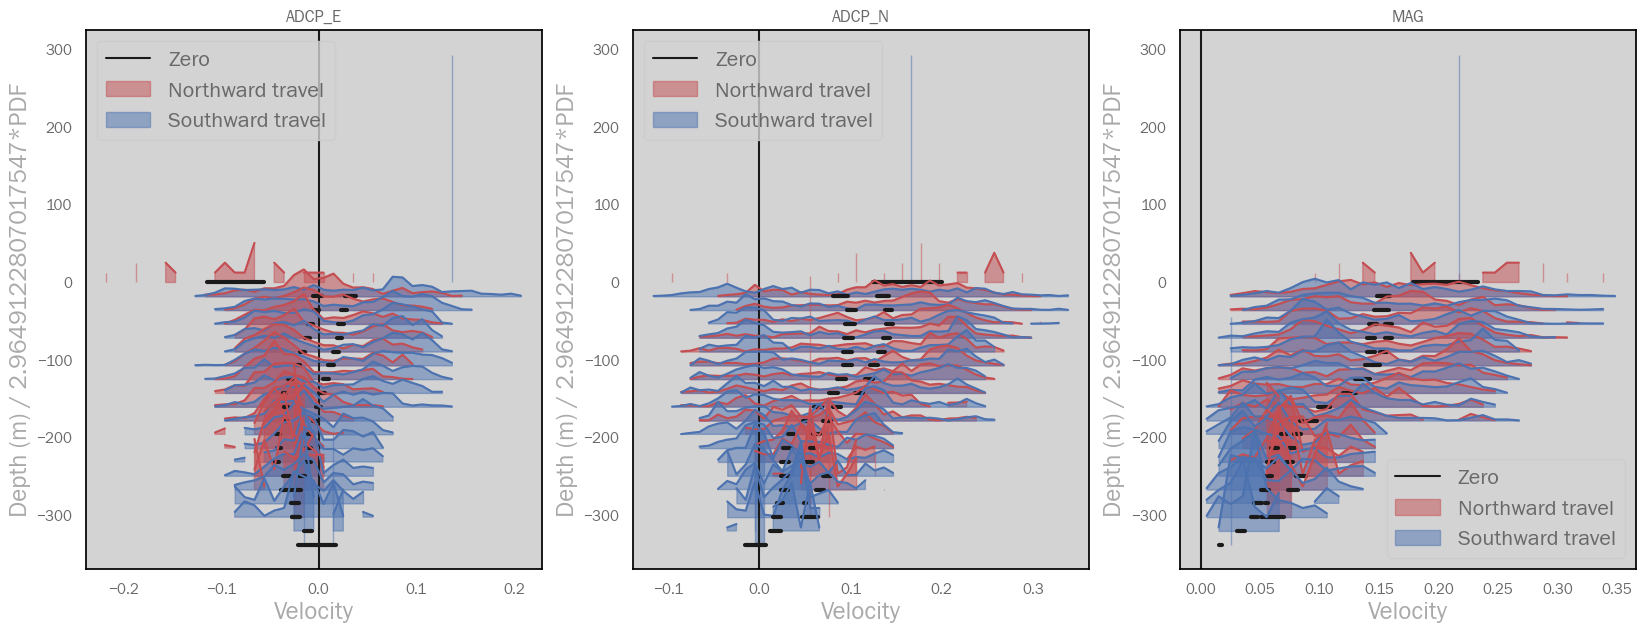

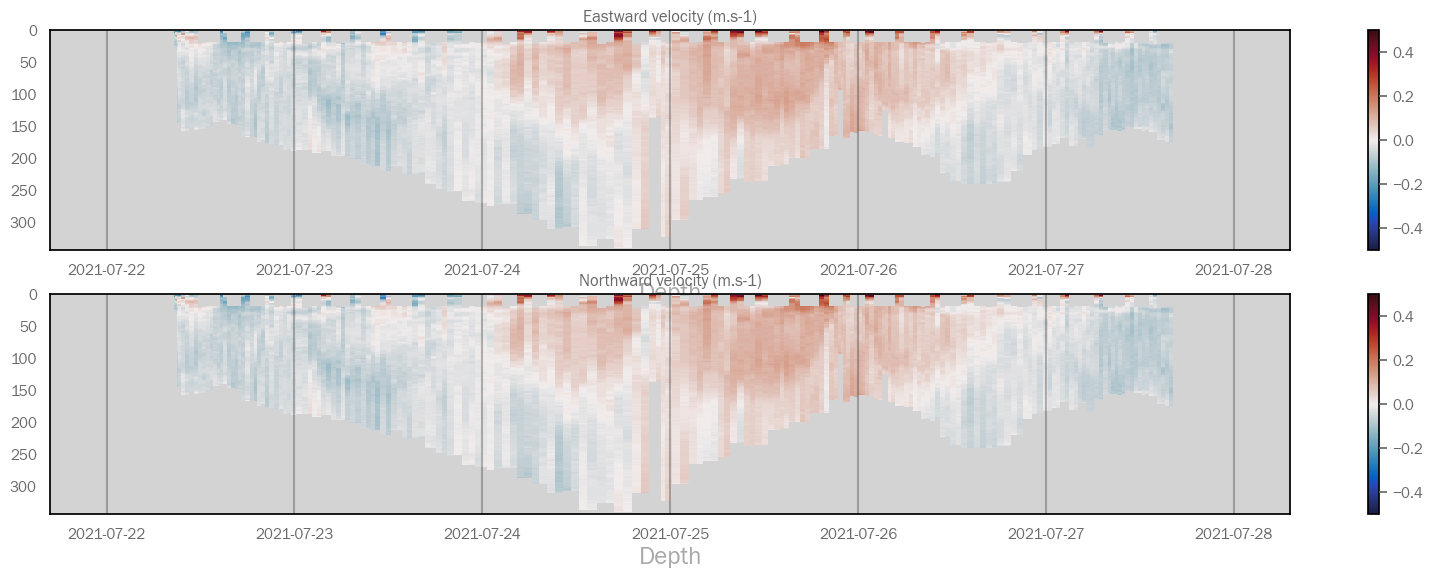

In [12]:
out = process_adcp.calc_bias(out, yaxis, taxis, days, options)

# Create xarray DataSet from `out` and compare results

In [13]:
ds = process_adcp.make_dataset(out)
ds_min = ds[['Sh_E', 'Sh_N','Sh_U', 'ADCP_E', 'ADCP_N']]

In [14]:
ds_min_test = xr.open_dataset("tests/test_files/ds_out_min.nc")

The processing chain uses some non-determinate functions that can produce small numerical differences in results, so we test with `numpy.allclose` rather than `equals`

In [15]:
for var in list(ds_min):
    assert np.allclose(ds_min[var], ds_min_test[var], equal_nan=True, atol=1e-7, rtol=1e-3)